# **Non-Stationary Federated Learning**



*   Deep Learning Framework: **PyTorch**
*   Dataset: **Synthetic**
*   Workers: **4**
*   Data Distribution: **IID on workers**





## Importing libraries and setting parameters for training


In [173]:
import torch
import torch.nn as nn
import torch.nn.functional as F


import os
import numpy as np
import math

from Stationary.core import *
from Stationary.utils import *

from sklearn import linear_model, datasets
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

In [174]:
num_workers = 4
num_rounds = 10

## Synthetic Dataset

We create a synthetic dataset, reproducing a linear correlation between inputs and outputs, with the addition of a noise.

Train set is divided into multiple slots, in order to reproduce the "online" approach: For each round, each worker has a different set for training phase.


In [209]:
# Linear Regression Coefficients
m = 1.4
c = 10

dataset_X = np.linspace(0, 10, 300)
np.random.shuffle(dataset_X)

dataset_y =  dataset_X * m + c +  np.random.randn(dataset_X.size) * math.sqrt(3)

dataset_X = dataset_X.reshape(-1,1)
dataset_y = dataset_y.reshape(-1,1)

In [210]:
train_percentage = 0.9


train_X, test_X = np.split(dataset_X, 
            [int(train_percentage * len(dataset_X))
            ])

train_y, test_y = np.split(dataset_y, 
            [int(train_percentage * len(dataset_y))
            ])

In [211]:
train_list_X = splitDataset(train_X, num_workers, num_rounds)
train_list_y = splitDataset(train_y, num_workers, num_rounds)

In [212]:
worker_list = []
for i in range(0, num_workers):
    worker_list.append(Worker(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), model=linear_model.LinearRegression()))

In [213]:
server = Server(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), workers = worker_list, num_features = dataset_X[0].size)

In [214]:
error = []
score = []

for i in range(0, num_rounds):
    
    for j in range(0, num_workers):
        worker_list[j].train(X = train_list_X[i*num_workers+j] , y = train_list_y[i*num_workers+j])

    server.aggregation() 
    server.return_to_workers()
    
    pred_server = server.evaluate(test_X)
    print('------ROUND {}------'.format(i+1))
    print('Mean squared error: %.3f' 
          % mean_squared_error(test_y, pred_server))
    print('Coefficient of determinaton: %.3f \n'
          % r2_score(test_y, pred_server))
    error.append(mean_squared_error(test_y, pred_server))
    score.append(r2_score(test_y, pred_server))

------ROUND 1------
Mean squared error: 5.619
Coefficient of determinaton: 0.575 

------ROUND 2------
Mean squared error: 3.022
Coefficient of determinaton: 0.772 

------ROUND 3------
Mean squared error: 2.894
Coefficient of determinaton: 0.781 

------ROUND 4------
Mean squared error: 2.860
Coefficient of determinaton: 0.784 

------ROUND 5------
Mean squared error: 2.919
Coefficient of determinaton: 0.779 

------ROUND 6------
Mean squared error: 2.881
Coefficient of determinaton: 0.782 

------ROUND 7------
Mean squared error: 2.891
Coefficient of determinaton: 0.782 

------ROUND 8------
Mean squared error: 3.037
Coefficient of determinaton: 0.771 

------ROUND 9------
Mean squared error: 3.034
Coefficient of determinaton: 0.771 

------ROUND 10------
Mean squared error: 2.985
Coefficient of determinaton: 0.774 



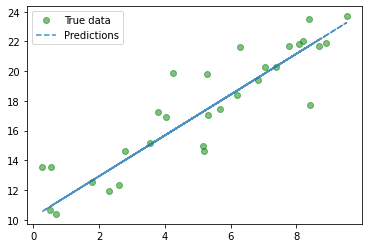

In [154]:
plt.clf()
plt.plot(test_X, test_y, 'go', label='True data', alpha=0.5)
plt.plot(test_X, pred_server, '--', label='Predictions', alpha=0.8)
plt.legend(loc='best')
plt.show()

# Federated Averaging

Implementation of FedAVG in PyTorch. 

First of all, the dataset is converted in tensors.
Then, a model, a loss function and an optimizer are instantiated for each worker.
Model parameters are averaged at each round.

In [215]:
from torch.autograd import Variable

for i in range(0, len(train_list_X)):
    train_list_X[i] = torch.from_numpy(train_list_X[i])

for i in range(0, len(train_list_y)):
    train_list_y[i] = torch.from_numpy(train_list_y[i])

## Model


In [262]:
class linearRegression(torch.nn.Module):
    
    def __init__(self, inputSize, outputSize):
        
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize, bias=True)

        
    def forward(self, x):
        
        out = self.linear(x)
        return out


In [263]:
w = []

for i in range(0, num_workers):
    
    w.append(linearRegression(dataset_X[0].size, dataset_y[0].size))
    w[i] = w[i].float()

In [264]:
learning_rate = 1e-4

criterion = []
optimizers = []

for i in w:
    
    criterion.append(torch.nn.MSELoss()) 
    optimizers.append(torch.optim.SGD(i.parameters(), lr=learning_rate))

In [265]:
params = []


for i in w:
    params.append(list(i.parameters()))

In [266]:
local_epochs = 100



for model in w:
    
    model.train()

for i in range(num_rounds):

    for j in range(0, num_workers):

        for epoch in range(local_epochs):
            
            optimizers[j].zero_grad()
            loss = 0
            
            for x in range(len(train_list_X[i*num_workers+j])):
                inputs = (train_list_X[i*num_workers+j][x]).float()
                labels = (train_list_y[i*num_workers+j][x]).float()
                y_pred = w[j](inputs)
                loss += criterion[j](y_pred, labels)
            
            loss.backward()
            print("Epoch: {},  Worker: {} ".format(epoch, j+1))
            optimizers[j].step()
 
    new_params = list()

    for param_i in range(len(params[0])):

        spdz_params = list()

        for remote_index in range(len(w)):
            spdz_params.append(params[remote_index][param_i].data)
        
        new_param = (torch.stack(spdz_params, dim=0).sum(dim=0).sum(dim=0))/len(w)
        new_params.append(new_param)
    
    print(params)
    
    with torch.no_grad():
        for model in params:
            for param in model:
                param *= 0
        
        for remote_index in range(len(w)):
            for param_index in range(len(params[remote_index])):
                params[remote_index][param_index].set_(new_params[param_index])
    
    

Epoch: 0,  Worker: 1 
Epoch: 1,  Worker: 1 
Epoch: 2,  Worker: 1 
Epoch: 3,  Worker: 1 
Epoch: 4,  Worker: 1 
Epoch: 5,  Worker: 1 
Epoch: 6,  Worker: 1 
Epoch: 7,  Worker: 1 
Epoch: 8,  Worker: 1 
Epoch: 9,  Worker: 1 
Epoch: 10,  Worker: 1 
Epoch: 11,  Worker: 1 
Epoch: 12,  Worker: 1 
Epoch: 13,  Worker: 1 
Epoch: 14,  Worker: 1 
Epoch: 15,  Worker: 1 
Epoch: 16,  Worker: 1 
Epoch: 17,  Worker: 1 
Epoch: 18,  Worker: 1 
Epoch: 19,  Worker: 1 
Epoch: 20,  Worker: 1 
Epoch: 21,  Worker: 1 
Epoch: 22,  Worker: 1 
Epoch: 23,  Worker: 1 
Epoch: 24,  Worker: 1 
Epoch: 25,  Worker: 1 
Epoch: 26,  Worker: 1 
Epoch: 27,  Worker: 1 
Epoch: 28,  Worker: 1 
Epoch: 29,  Worker: 1 
Epoch: 30,  Worker: 1 
Epoch: 31,  Worker: 1 
Epoch: 32,  Worker: 1 
Epoch: 33,  Worker: 1 
Epoch: 34,  Worker: 1 
Epoch: 35,  Worker: 1 
Epoch: 36,  Worker: 1 
Epoch: 37,  Worker: 1 
Epoch: 38,  Worker: 1 
Epoch: 39,  Worker: 1 
Epoch: 40,  Worker: 1 
Epoch: 41,  Worker: 1 
Epoch: 42,  Worker: 1 
Epoch: 43,  Worker: 1

RuntimeError: output with shape [1] doesn't match the broadcast shape [1, 1]

In [ ]:

with torch.no_grad(): 
    predicted = w[0](Variable(torch.from_numpy(test_X).float())).data.numpy()

plt.clf()
plt.plot(test_X, test_y, 'go', label='True data', alpha=0.5)
plt.plot(test_X, predicted, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()